In [1]:
import iris
import xarray as xr
import numpy as np
import pandas as pd
from eofs.xarray import Eof
from eofs.multivariate.iris import MultivariateEof
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import iris.quickplot as qplt

In [2]:
path = "/mnt/c/Users/susaw/Desktop/JRA-55_subsets/*.nc"

In [3]:
def open_data(path):
    df = xr.open_mfdataset(path,chunks={'initial_time0_hours':504,'g0_lat_1':29,'g0_lon_2':29})
    df = df.rename({'initial_time0_hours':'time','g0_lat_1':'lat','g0_lon_2':'lon'}).drop("initial_time0_encoded")
    df.coords['lon'] = (df.coords['lon'] + 180) % 360 - 180
    return df

In [4]:
def calc_normalized_anomalies(ds_prep, window_size=21):
    """
    This method prepares the input Dataset. It calculates the normalized anomalies with means
    and std calculated with a centered window of size window_size
    """

    # Resample with mean over data if temporal resolution is higher than daily (Lower resolution not supported here)
    if pd.infer_freq(ds_prep.time.data) not in 'D':
        ds_prep = ds_prep.resample(time='1D').mean()
        ds_prep = ds_prep.chunk({'time':-1})

    # calculates the climatology and the standard deviation for further anomaly calculation
    ds_prep_roll = ds_prep.rolling(time=window_size, center=True).construct('window_dim') # creates the rolling window as a new dimension

    # calculate climatology (dayofyear mean) for rolling window over Target Day ± 10days (pool)
    # IMPORTANT DIFFERENCE:
    # mean rolling window before meaning time: all windows where at least one timestep is missing are dropped
    # ds_prep_clim_alt = ds_prep.rolling(time=window_size, center=True).mean().groupby('time.dayofyear').mean('time')

    # mean after construct with dropna: same as above (all windows, where at least one timestep is missing are dropped)
    # ds_prep_clim = ds_prep_roll.dropna('time').groupby('time.dayofyear').mean(dim=['window_dim','time'])

    # mean after construct without dropna: first and last windows are considered, even if there are timesteps with missing values
    ds_prep_clim = ds_prep_roll.groupby('time.dayofyear').mean(dim=['window_dim','time'])

    # calculate standard deviation (dayofyear std) for rolling window over Target Day ± 10days (pool)
    ds_prep_std = ds_prep_roll.groupby('time.dayofyear').std(dim=xr.ALL_DIMS) # Calculates the std for dayofyear of TD + pool, shape(365,)

    # calculate daily normalized anomalies with mean and std from TD + pool
    ds_prep = ds_prep.groupby('time.dayofyear') - ds_prep_clim
    ds_prep = ds_prep.groupby('time.dayofyear') / ds_prep_std

    # Rechunking necessary after groupby
    ds_prep = ds_prep.chunk({'time': -1})

    return ds_prep

In [5]:
df = open_data(path)
df = df.rename({["PRMSL_GDS0_MSL","mslp"][0]:["PRMSL_GDS0_MSL","mslp"][1],["RH_GDS0_ISBL","rh"][0]:["RH_GDS0_ISBL","rh"][1],["SPFH_GDS0_ISBL","spfh"][0]:["SPFH_GDS0_ISBL","spfh"][1]}).drop("initial_time0")
df = calc_normalized_anomalies(df)

In [6]:
df

<xarray.Dataset>
Dimensions:    (lat: 29, lon: 29, time: 1461)
Coordinates:
  * lat        (lat) float32 67.5 66.25 65.0 63.75 ... 36.25 35.0 33.75 32.5
  * lon        (lon) float32 -10.0 -8.75 -7.5 -6.25 ... 21.25 22.5 23.75 25.0
  * time       (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1961-12-31
    dayofyear  (time) int64 dask.array<shape=(1461,), chunksize=(1461,)>
Data variables:
    mslp       (time, lat, lon) float32 dask.array<shape=(1461, 29, 29), chunksize=(1461, 29, 29)>
    rh         (time, lat, lon) float32 dask.array<shape=(1461, 29, 29), chunksize=(1461, 29, 29)>
    spfh       (time, lat, lon) float32 dask.array<shape=(1461, 29, 29), chunksize=(1461, 29, 29)>

/home/susa/anaconda3/envs/env1/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


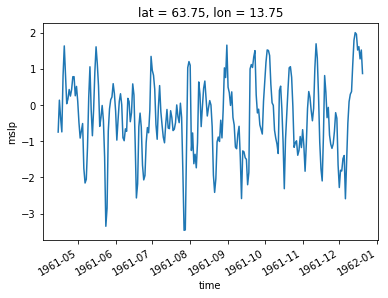

In [7]:
df.mslp[1200:1450,3,19].plot()

In [8]:
df_roll = df.rolling(time=21,center=True).construct("window_dim")

In [9]:
for day in df_roll.groupby("time.dayofyear"):
    cube = day[1].rename({"time":"time_old"}).stack(time = ("time_old","window_dim")).reset_index("time").transpose("time","lat","lon").dropna("time")
    cube_mslp = cube.mslp.assign_coords(time=range(0,len(cube.time))).to_iris()
    cube_rh = cube.rh.assign_coords(time=range(0,len(cube.time))).to_iris()
    solver = MultivariateEof([cube_mslp,cube_rh])#,weights="coslat")

In [24]:
len(cube.time)

21

In [28]:
cube.rh

<xarray.DataArray 'rh' (time: 21, lat: 29, lon: 29)>
dask.array<shape=(21, 29, 29), dtype=float32, chunksize=(21, 29, 29)>
Coordinates:
  * lat         (lat) float32 67.5 66.25 65.0 63.75 ... 36.25 35.0 33.75 32.5
  * lon         (lon) float32 -10.0 -8.75 -7.5 -6.25 ... 21.25 22.5 23.75 25.0
    dayofyear   (time) int64 dask.array<shape=(21,), chunksize=(21,)>
    time_old    (time) datetime64[ns] 1960-12-31 1960-12-31 ... 1960-12-31
    window_dim  (time) int64 0 1 2 3 4 5 6 7 8 9 ... 12 13 14 15 16 17 18 19 20
Dimensions without coordinates: time

In [20]:
cube_mslp

Mslp (unknown),time,latitude,lon
Shape,74,29,29
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
lon,-,-,x
Auxiliary coordinates,,,
dayofyear,x,-,-
time_old,x,-,-
window_dim,x,-,-


In [21]:
cube_rh

Rh (unknown),time,latitude,lon
Shape,74,29,29
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
lon,-,-,x
Auxiliary coordinates,,,
dayofyear,x,-,-
time_old,x,-,-
window_dim,x,-,-


In [27]:
eofs_list = solver.eofsAsCorrelation(neofs=5)#eig 2??

In [28]:
eofs_list

[<iris 'Cube' of correlation_between_pcs_and_mslp / (unknown) (eof_number: 5; latitude: 29; lon: 29)>,
 <iris 'Cube' of correlation_between_pcs_and_rh / (unknown) (eof_number: 5; latitude: 29; lon: 29)>]

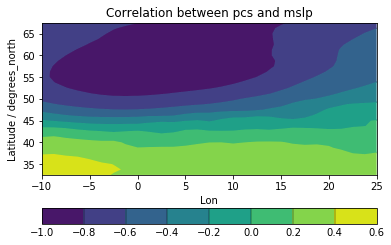

In [39]:
qplt.contourf(eofs_list[0][0])
plt.show()

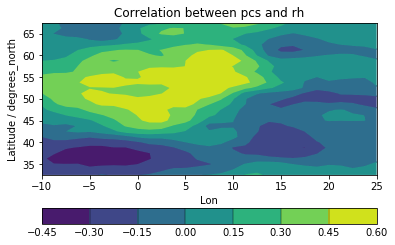

In [33]:
qplt.contourf(eofs_list[1][0])
plt.show()

In [49]:
j=1
while (j<=10):
    if np.sum(solver.varianceFraction(neigs=j).data)<=0.90:
        j=j+1
    else:
        break
eof_list_09 = solver.eofs(neofs=j)
pc_list_09 = solver.pcs(npcs=j)

In [50]:
eof_list_09

[<iris 'Cube' of empirical_orthogonal_functions / (unknown) (eof_number: 11; latitude: 29; lon: 29)>,
 <iris 'Cube' of empirical_orthogonal_functions / (unknown) (eof_number: 11; latitude: 29; lon: 29)>]

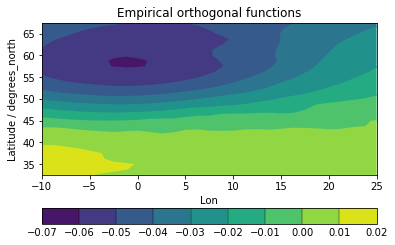

In [52]:
qplt.contourf(eof_list_09[0][0])
plt.show()

In [60]:
mslp=cube_mslp.data

In [61]:
rh = cube_rh.data

In [64]:
pseudo_pcs = solver.projectField([cube_mslp,cube_rh],neofs=11)

In [82]:
pseudo_pcs

Pseudo Pcs (unknown),time,pc_number
Shape,74,11
Dimension coordinates,,
time,x,-
pc_number,-,x
Auxiliary coordinates,,
dayofyear,x,-
time_old,x,-
window_dim,x,-


In [67]:
pcs = pc_list_09.data

In [69]:
ps_pcs = pseudo_pcs.data

In [70]:
norm = np.sum(np.sqrt((pcs - ps_pcs)**2),axis=1)

In [71]:
norm

array([8.614686 , 8.614683 , 8.614689 , 8.614677 , 8.614677 , 8.61469  ,
       8.614679 , 8.614686 , 8.614675 , 8.6146755, 8.614686 , 8.614685 ,
       8.614685 , 8.61468  , 8.614681 , 8.614679 , 8.61468  , 8.61468  ,
       8.614684 , 8.614684 , 8.614691 , 8.614682 , 8.614678 , 8.614687 ,
       8.614683 , 8.614681 , 8.614683 , 8.614682 , 8.614679 , 8.614679 ,
       8.614686 , 8.614687 , 8.614682 , 8.614681 , 8.614685 , 8.614682 ,
       8.614674 , 8.614685 , 8.614681 , 8.614682 , 8.61468  , 8.614683 ,
       8.614683 , 8.614681 , 8.61468  , 8.614679 , 8.61468  , 8.614687 ,
       8.614685 , 8.614677 , 8.614672 , 8.614691 , 8.614685 , 8.61468  ,
       8.614678 , 8.614686 , 8.614683 , 8.614681 , 8.614678 , 8.614679 ,
       8.614685 , 8.614679 , 8.614683 , 8.614683 , 8.614684 , 8.614683 ,
       8.614686 , 8.614683 , 8.614686 , 8.614683 , 8.614681 , 8.614681 ,
       8.614685 , 8.614686 ], dtype=float32)

In [72]:
norm_min = np.argmin(norm)

In [73]:
norm_min

50

In [97]:
pcx=xr.DataArray.from_iris(pseudo_pcs)
pcx.time_old[50]

<xarray.DataArray 'time_old' ()>
array('1960-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time        int64 50
    dayofyear   int64 ...
    time_old    datetime64[ns] ...
    window_dim  int64 ...